In [36]:
import collections
import math
import torch
from torch import nn
import mdl.md2l as mdl
from d2l import torch as d2l

# 序列到序列学习(seq2seq)
这里使用两个循环神经网络的编码器和解码器, 应用在序列到序列类的学习任务中

根据 `Encoder-Decoder` 架构的设计原则, `RNN` 编码器使用长度可变的序列作为输入, 将其转换为固定形状的隐状态, **输入序列的信息被比编码到循环神经网络编码器的隐状态中** ;

同时为了连续生成输出序列的词元, **独立的循环神经网络编码器是基于输入序列的编码信息和输出序列已经看到的或者生成的词来预测下一个词元**, 下图演示了机器翻译任务在使用两个循环神经网络进行序列到序列学习:
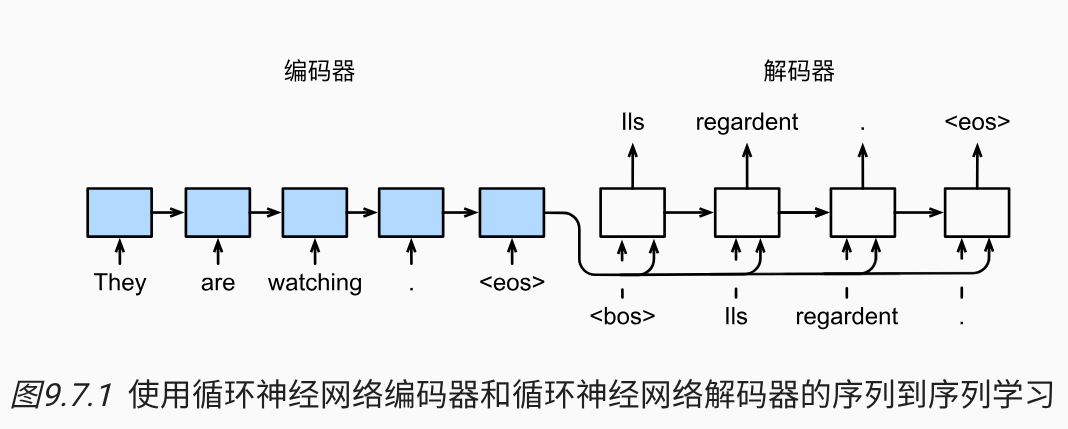
图中 `<eos>` 表示序列结束词元, 一旦输出序列生成此词元 ; 在 `RNN Decoder`的初始化时间步, 有两个特殊的设计, 特定的 `<bos>` 表示序列开始词元, 它是编码器的输入序列的第一个词元 ; 其次, **使用循环神经网络编码器最终的隐状态来初始化编码器的隐状态**, 如上图, 编码器最终的隐状态在每一个时间步都作为编码器的 ; 同时类似于语言模型的训练, 可以允许标签称为原始的输出序列, 从源序列词元到新序列词元来移动预测的位置

## 编码器
**编码器的作用: 把长度可变的输入序列转换为形状固定的上下文变量 $\mathbf{c}$, 并且将输入序列的信息在该上下文变量进行编码**

考虑一个序列组成的样本(批量大小为 $1$), 假设输入序列是 $x_1, \ldots , x_T$, 其中 $x_t$ 是输入文本序列中的第 $t$ 个词元, 在时间步 $t$, 循环神经网络将词元 $x_t$ 的输入特征向量 $\mathbf{x}_t$ 和 $\mathbf{h}_{t-1}$(上一个时间步的隐状态), 转换为 $\mathbf{h}_t$(也就是当前步的隐状态), 可以使用一个函数 $f$ 来描述循环神经网络的循环层的变换(其实就隐藏层的变换):
$$
\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1})
$$
之后, 编码器通过选定的函数$q$, 将所有时间步的隐状态转换为上下文变量:
$$
\mathbf{c} = q(\mathbf{h}_1, \ldots, \mathbf{h}_T)
$$
比如, 如果选择 $q(\mathbf{h}_1, \ldots , \mathbf{h}_T) = \mathbf{h}_T$ 的时候, 上下文变量仅仅是输入序列在最后时间步的隐状态 $\mathbf{h}_T$, 此时表示上下文变量仅仅是输入序列在最后时间步的隐状态 $\mathbf{h}_T$

下面实现循环神经网络编码器, 这里使用**嵌入层**来获取输入序列的每一个词元的特征向量, 嵌入层的权重是一个矩阵, 输入行数等于词表大小, 列数等于特征向量的维度(也就是特征数量), 对于任意输入词元的索引$i$, 嵌入层获取权重矩阵的第$i$行(从$0$开始)以返回其特征向量 ; 并且时用一个 `GRU` 循环单元来实现编码器

**nn.Embedding** 是 `PyTorch` 中实现词嵌入的模块, 可以把离散的符号映射到连续的低维向量, 作用:
1. **存储词向量矩阵**: 作为一个可训练的查找表, 将每个索引映射到对应的向量, 例如一个包含 $n$ 个单词的索引, 每一个单词使用 $d$ 维向量表示(表示 $d$ 个特征, 比如如果使用字符作为词元, 那么对于一个单词就是单词长度个特征), 那么 `Embedding`矩阵大小为 $(n , d)$
2. **降维与语义表示**: 把高维系数的独热编码转换为低维密集向量
3. **自动梯度更新**: 作为神经网络的一层, `Embedding`参数可以通过反向传播自动优化

核心参数: 
- `num_embeddings`: 词典大小(索引范围为: `0 - num_embedding - 1`)
- `embedding_dim`: 每一个词的向量维度

In [37]:
# nn.Embedding 作用演示
# 创建一个嵌入层, 词表中含有 10 个词元, 并且每一个词元使用 3 维向量表示
embedding = nn.Embedding(num_embeddings=10, embedding_dim=3)
# 输入: (批量大小, 词元个数)
# 可以表示两个句子, 第一个句子含有词表中索引 1, 4, 7 的词元
#                第二个句子含有词表中索引 2, 5, 8 的词元
input_indices = torch.tensor([[1, 4, 7],[2, 5, 8]])
# 获取到词向量： 注意词向量表示 利用词元的编码(词向量矩阵单行)组成的词编码得到的矩阵
word_vectors = embedding(input_indices)
print('input index shape:\t\t', input_indices.shape)
print('word vectors shape:\t\t', word_vectors.shape)
print('the vector of the first word:\t', word_vectors[0, 0])

input index shape:		 torch.Size([2, 3])
word vectors shape:		 torch.Size([2, 3, 3])
the vector of the first word:	 tensor([ 0.3698,  0.7195, -0.6119], grad_fn=<SelectBackward0>)


**`nn.Embedding`补充**: 核心是一个表示词元编码的矩阵, 大小为`(词表大小, 表示单个词元维度数)` ; 对于特定的输入, 返回输入代表的词元的向量表示组成词向量矩阵(实际上是通过和特定的权重矩阵相乘得到), 并且核心的权重矩阵会随着训练而持续优化

In [38]:
# Seq2Seq编码器实现:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于Seq2Seq学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 注意输入特征数(d 越大, 描述越详细, 但是训练需要的资源也比较大)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, 
                          dropout=dropout)
    def forward(self, X, *args):
        # 输出 X 的形状: (batch_size, 词元个数(num_steps), embed_size)
        X = self.embedding(X)
        # 改变 X 维度 -> (num_steps, batch_size, embed_size)
        X = X.permute(1, 0, 2)
        # 如果未提及状态, 默认为 0
        output, state = self.rnn(X)
        # output 形状: (num_steps, batch_size, num_hiddens) 表示最后一层每一步的 H_t,关联输出
        # state  形状: (num_layer, batch_size, num_hiddens) 表示最后一部的 H_T
        return output, state

**补充: torch.Tensor.permute** 用于改变对应张量的形状, 用于维度的交换

In [39]:
# 演示 Seq2SeqEncoder 作用:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                        num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape # 注意第一个维度总是 num_steps 时间步

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

## 解码器
编码器输出上下文变量 $\mathbf{c}$对整个序列$x_1, \ldots, x_T$进行编码, 来自训练数据集的输出序列 $y_1, y_2, \ldots, y_{T'}$, 对于每一个时间步 $t'$, 解码器输出的 $y_{t'}$的概率取决于先前的输出子序列$y_1, \ldots, y_{t'-1}$和上下文变量$\mathbf{c}$, 也就是 $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$

为了序列上模型化这种模型概率, 可以使用另外一个循环神经网络作为编码器, 在输出序列上的任意时间步 $t'$, 循环神经网络将来自上一个时间步的输出$y_{t'-1}$和上下文变量$\mathbf{c}$作为其输入, 然后在当前时间步将它们和上一隐状态$\mathbf{s}_{t'-1}$转换为隐状态$\mathbf{s}_{t'}$, 可以使用函数$g$表示编码器的隐藏层的变换:
$$
\mathbf{s}_{t'} = g(y_{t'-1}, \mathbf{c}, \mathbf{s}_{t'-1})
$$
获取到编码器隐状态之后, 可以使用输出层和 `softmax` 操作来计算时间步 $t'$ 时输出 $y_{t'}$的条件概率分布 $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$

**编码器实现**: 直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态, 此时要求解码器和编码器使用的循环神经网络具有相同数量的层和隐藏单元, 同时为了进一步包含经过编码的输入序列的信息, 上下文变量在所有的时间步和解码器的输入进行拼接 , 同时最后一层使用全连接层来变换隐状态

In [40]:
class Seq2SeqDecoder(d2l.Decoder):
    """Seq2Seq学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 注意输入,  词元+中间状态(二者特征相加)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, 
                          num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1] # 最后一个隐状态作为当前隐状态
    def forward(self, X, state):
        # 输出 X 形状: (batch_size, num_steps, embed_size)
        # 转换形状 X -> (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 上下文变量 context
        # state: 表示最后一个时间步双层隐状态
        # (num_layer, batch_size, num_hiddens)
        # torch.Tensor.repeat 的作用: 沿着不同方向复制
        # context 形状 -> (num_steps, batch_size, num_hiddens), 用于拼接输入
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2) # 沿着最后一个维度拼接
        output, state = self.rnn(X_and_context, state) # 使用最后一个隐状态作为隐状态
        output = self.dense(output).permute(1, 0, 2)
        # output shape: (batch_size, num_steps, vocab_size) 
        # state  shape: (num_layer, batch_size, num_hiddens)
        return output, state

In [41]:
# 测试解码器形状
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                        num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

**整个 Encoder-Decoder 架构如下:**
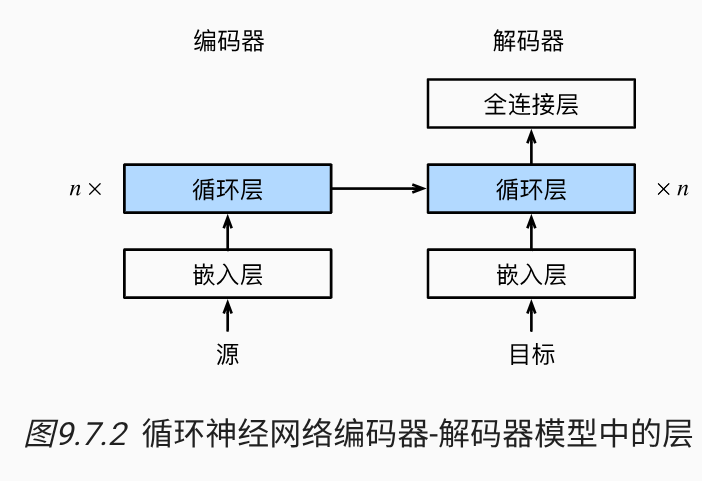

## 损失函数
编码器可以预测词元的概率分布, 类似于语言模型, 可以使用 `softmax` 来获取分布, 并且通过计算份交叉熵函数来优化损失 ; 同时注意需要把填充的词元的预测排除在损失函数的计算之外(之前通过填充词元的方式来保持序列长度一致)

In [42]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1) # X.shape = (batch_size, num_steps), 取出步长
    mask = torch.arange((maxlen), dtype=torch.float32, 
                        device=X.device)[None, :] < valid_len[:,None]
    X[~mask] = value # 注意 Bool 型索引的使用方式
    return X

In [43]:
# 测试 sequence_mask 的基本使用
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

**补充**: 注意这里 `X[:, None]`, 表示把 $X$ 进行维度拓展 `(n,) -> (n, 1)`, 同时这里 `X[None, :]` 表示把 $X$ 进行维度拓展 `(n,) -> (1, n)`, 之后发生广播机制, 可以看作, 超出了 `valid_len` 的位置都会被修改为 `value`

下面通过拓展`softmax`交叉熵损失函数来遮盖不相关的预测 ; 最初, 所有预测词元的掩码都设置为 $1$, 一旦给定有效长度, 与填充词元对应的掩码将设置为 $0$, 最后把所有词元的损失乘以掩码, 从而过滤掉损失中填充词元产生的不相关预测

In [44]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred.shape  (batch_size, num_steps, vocab_size)
    # label.shape (batch_size, num_steps)
    # valid_len   (batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [45]:
# 验证损失函数
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

**补充:**
注意 `nn.CrossEntropyLoss`的输入和输出:
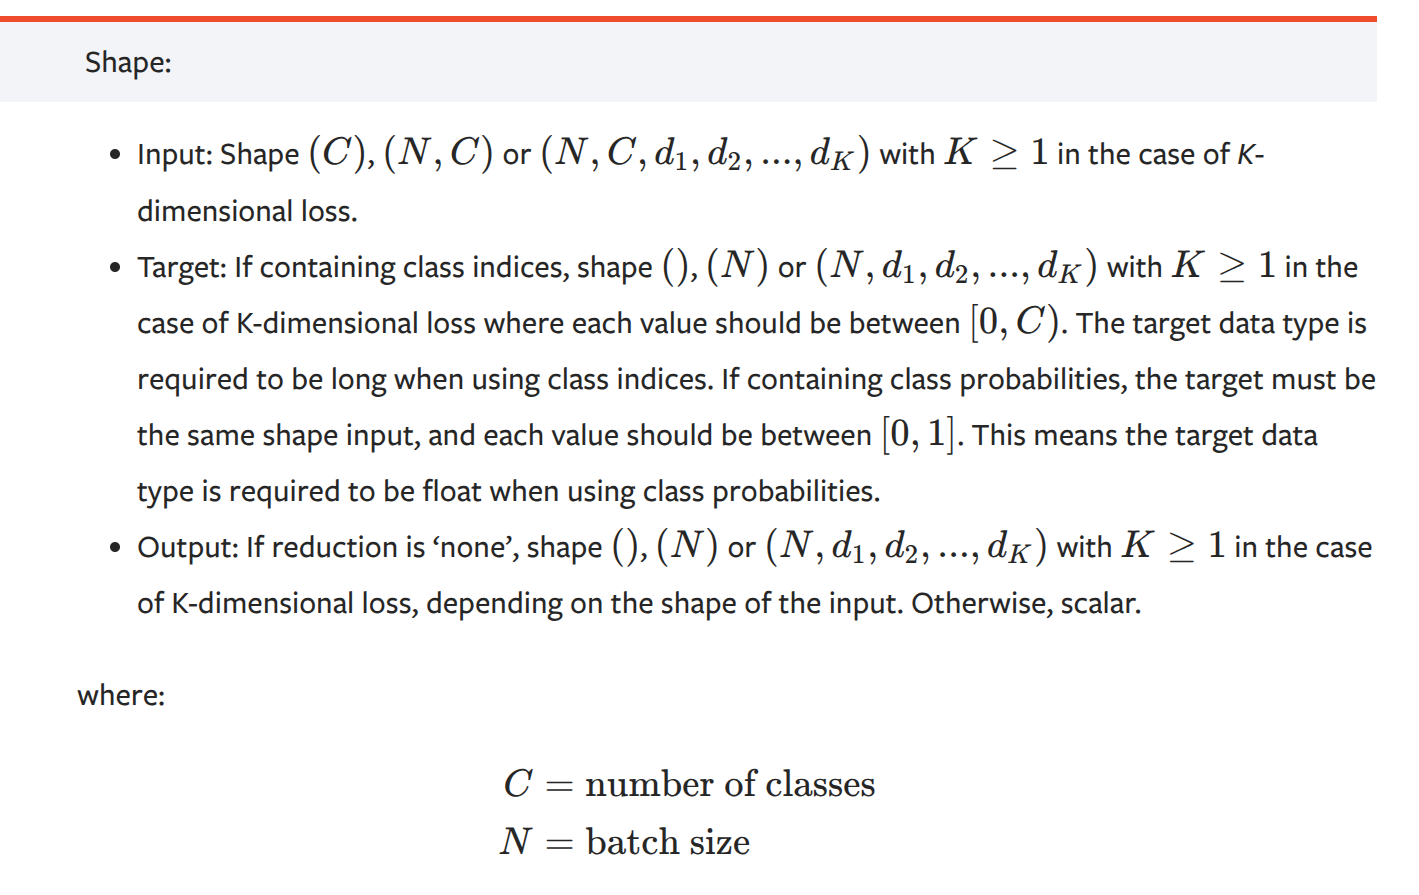
**计算流程:** 
- 输入 `input`: 形状为 `(batch_size, C, d1, d2, ..., d_k)`, `C`为类别数
- 目标 `target`: 形状为: `(batch_size, D1, D2, ... , D_k)`
- 输出 `output`: 形状为: `(d1, d2, ... d_k)`
首先计算损失函数, 对于单个样本的第 $n$ 个特征, 损失函数的计算方法为:
$$
l_n = - \sum_{c=1}^{C} w_c \log \frac{\exp^{d_n}}{\sum_{i=1}^{c} d_i} 
$$
**其中 $d_n$ 为 $pred$ 中 $D_n$ 对应位置的概率, $w_c$ 为权重**, 同时如果设置 `reduction=none`, 那么 $l(x, y) = L = \{l_1, \ldots, l_N \}^T$, 并且其中 $l_n$ 就是上式, 其中 $N$ 为批量, $C$ 为类别数量(分类问题中讨论类型数)

## 模型训练
在下面训练过程中, 特定的序列开始词元 `<bos>` 和原始输出序列 (不包括序列结尾词元 `<eos>`) 拼接在一起作为解码器输入, 称为强制教学

In [46]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    # 使用 xavier 算法初始化模型参数
    net.apply(xavier_init_weights)
    net.to(device)
    # 使用 Adam 作为优化器
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # 遮蔽有效长度之外的部分的 CrossEntropyLoss作为损失函数
    loss = MaskedSoftmaxCELoss()
    # Model 设置为训练状态
    net.train()
    # 绘图工具
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.019, 16227.8 tokens/sec on cpu


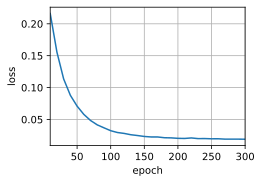

In [47]:
# 模型训练
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = mdl.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 预测
每一个解码器当前时间步的输入都将来自于前一个时间步的预测词元, 和训练类似, 序列开始词元 `<bos>` 在初始时间步被输入到解码器中, 预测过程如下, 并且当输入序列的预测遇到序列结束词元 `<eos>` 的时候, 预测结束:
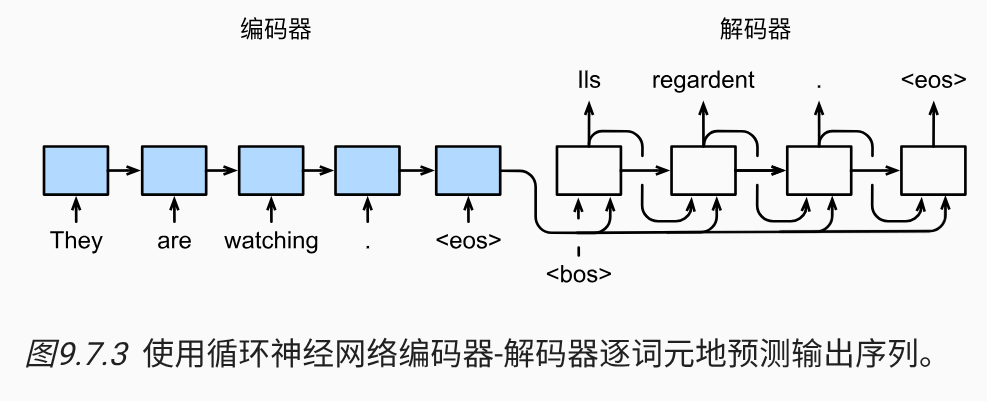

In [23]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    # 给原始 token 加上 <eos>
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    # 设置 token 有效长度
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## 预测序列的评估
可以通过对比真实的标签序列来比较评估序列, 比如 `BLEU` 算法可以用于评估机器翻译, 但是现在已经被广泛用于许多应用序列的质量 ; 对于预测序列中的任意 $n$ 元语法, `BLEU` 评估都是在这 $n$ 元语法是否出现在标签序列中, 定义如下:
$$
\exp\left( \min\left( 0, 1 - \frac{\text{len}_\text{label}}{\text{len}_\text{pred}} \right) \right) \prod_{n=1}^k p_n^{1/2^n},
$$
其中 $len_{label}$表示标签序列中的词元数量和 $len_{pred}$ 表示预测序列中的词元数, $k$ 是用于匹配的最长的 $n$ 元语法, 另外使用 $p_n$ 表示 $n$ 元语法的精确度, 它是两个数量的比值: 第一个是预测序列与标签序列中匹配的 $n$ 元语法的数量, 第二个是预测序列中 $n$ 元语法的数量比如

`BLEU` 实现如下:

In [24]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [25]:
# 最终对于训练好的循环神经网络模型进行测试可以得到
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu bien !, bleu 0.537
he's calm . => il est court de partie partie partie partie partie suis, bleu 0.258
i'm home . => je suis chez moi <unk> ., bleu 0.803
